# Homework 3. 
# I. Decision Tree.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [1]:
import numpy as np
import pandas as pd
import math

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [2]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
df.drop('Survived', axis=1, inplace=True)

In [3]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

In [4]:
df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Разделение на train, test

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [6]:
X_train['target'] = y_train

<ipython-input-6-be68b596246c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['target'] = y_train


In [7]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [8]:
def get_target(df):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1
        
        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """

    # YOUR CODE HERE
    if (df == 0).sum() > (df == 1).sum():
        return 0
    else:
        return 1

In [9]:
def get_entropy(target):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)
        
        Output - значение энтропии (тип - float)
    """
    # YOUR CODE HERE
    p0 = (target == 0).sum() / target.size
    p1 = (target == 1).sum() / target.size
    if p0 == 0:
        entropy = abs(- p1 * np.log2(p1))
    elif p1 == 0:
        entropy = abs(- p0 * np.log2(p0))
    else:
        entropy = abs(- p0 * np.log2(p0) - p1 * np.log2(p1))
    
    return entropy

In [10]:
"""
s = pd.Series([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])
get_entropy(s)
"""

'\ns = pd.Series([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])\nget_entropy(s)\n'

In [11]:
"""
s0 = get_entropy(s)
s1 = get_entropy(s[:1])
s2 = get_entropy(s[1:])
threshold = (s[0] + s[1]) / 2
delta_entropy = s0 - (s[:1].size / s.size * s1 + s[1:].size / s.size * s2)
for i in range(2, s.size):
    s1 = get_entropy(s[:i])
    s2 = get_entropy(s[i:])
    ig = s0 - (s[:i].size / s.size * s1 + s[i:].size / s.size * s2)
    if ig > delta_entropy :
        delta_entropy = ig
        threshold = (s[i-1] + s[i]) / 2
print (delta_entropy, threshold)
"""

'\ns0 = get_entropy(s)\ns1 = get_entropy(s[:1])\ns2 = get_entropy(s[1:])\nthreshold = (s[0] + s[1]) / 2\ndelta_entropy = s0 - (s[:1].size / s.size * s1 + s[1:].size / s.size * s2)\nfor i in range(2, s.size):\n    s1 = get_entropy(s[:i])\n    s2 = get_entropy(s[i:])\n    ig = s0 - (s[:i].size / s.size * s1 + s[i:].size / s.size * s2)\n    if ig > delta_entropy :\n        delta_entropy = ig\n        threshold = (s[i-1] + s[i]) / 2\nprint (delta_entropy, threshold)\n'

In [12]:
def feature_separation(df, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target), 
                f_name: название фичи (для которой ищем разбиение)
                
        Output - прирост энтропии, порог разбиения
    """
    
    # YOUR CODE HERE
    """
    df.index = np.arange(len(df))
    f = df[f_name]
    
    s0 = get_entropy(f)
    s1 = get_entropy(f[:1])
    s2 = get_entropy(f[1:])
    threshold = (f[0] + f[1]) / 2
    delta_entropy = s0 - (f[:1].size / f.size * s1 + f[1:].size / f.size * s2)
    for i in range(2, f.size):
        s1 = get_entropy(f[:i])
        s2 = get_entropy(f[i:])
        ig = s0 - (f[:i].size / f.size * s1 + f[i:].size / f.size * s2)
        if ig > delta_entropy :
            delta_entropy = ig
            threshold = (f[i-1] + f[i]) / 2
    """
    flag = True
    s0 = get_entropy(df['target'])
    for i in df[f_name]:
        g1 = df[df[f_name] <= i]
        g2 = df[df[f_name] > i]
        s1 = get_entropy(g1['target'])
        s2 = get_entropy(g2['target'])
        ig = s0 - (g1.size / df['target'].size * s1 + g2.size / df['target'].size * s2)
        if flag:
            delta_entropy = ig
            threshold = (i + (i+1)) / 2
            flag = False
        if ig > delta_entropy :
            delta_entropy = ig
            threshold = (i + (i+1)) / 2
    return (delta_entropy, threshold)


In [13]:
def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    
    sep_feature, threshold = None, None
    flag = False
    all_features = [c for c in df.columns.tolist() if c != 'target']

    for f in all_features:
        # YOUR CODE HERE
        delta, t = feature_separation(df, f)
        if not flag:
            flag = True
            sep_feature = f 
            threshold = t
            bestdelta = delta
        elif delta > bestdelta:
            bestdelta = delta
            sep_feature = f 
            threshold = t 
    g1 = df.loc[df[sep_feature] < threshold]
    g2 = df.loc[df[sep_feature] >= threshold]
    groups = (g1, g2)
    return {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}

In [14]:
def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    
    df_left, df_right = node['groups']
    sep_feature = node['feature_name']
    print(sep_feature)
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
        #print('Адыхай')
        node['left'] = node['right'] = get_target(pd.concat([df_left, df_right]).target) # YOUR CODE HERE
        return
    
    # проверяем максимальную глубину
    if depth >= max_depth:
        node['left'], node['right'] = get_target(df_left.target), get_target(df_right.target)  # YOUR CODE HERE
        return
    
    else:
        #print('го налево')
        node['left'] = best_separation(df_left) # YOUR CODE HERE
        split(node['left'], max_depth, depth + 1)
        
        #print('го направо')
        node['right'] = best_separation(df_right) # YOUR CODE HERE
        split(node['right'], max_depth, depth + 1)
        

In [15]:
def fit_my_tree(df, max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """    
    root = best_separation(df)
    split(root, max_depth, 1)

    return root

In [16]:
my_tree = fit_my_tree(X_train, 3)

<ipython-input-9-48107d3bf439>:9: RuntimeWarning: invalid value encountered in long_scalars
  p0 = (target == 0).sum() / target.size
<ipython-input-9-48107d3bf439>:10: RuntimeWarning: invalid value encountered in long_scalars
  p1 = (target == 1).sum() / target.size


Sex_male
Pclass_3
Fare
Fare
Fare
Age
Fare


## Predict MyDecisionTree  

In [17]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """    
    if row[tree['feature_name']] <= tree['threshold']:
        if type(tree['left']) == dict:
            return predict_raw(row, tree['left'])
        else:
            return tree['left']
    else:
        if type(tree['right']) == dict:
            return predict_raw(row, tree['right'])
        else:
            return tree['right']
    
    
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, my_tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [18]:
my_pred_test = predict_my_tree(X_test, my_tree)
my_pred_train = predict_my_tree(X_train, my_tree)

<ipython-input-17-502e52ba210a>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predict = pd.Series()


## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [19]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [20]:
clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

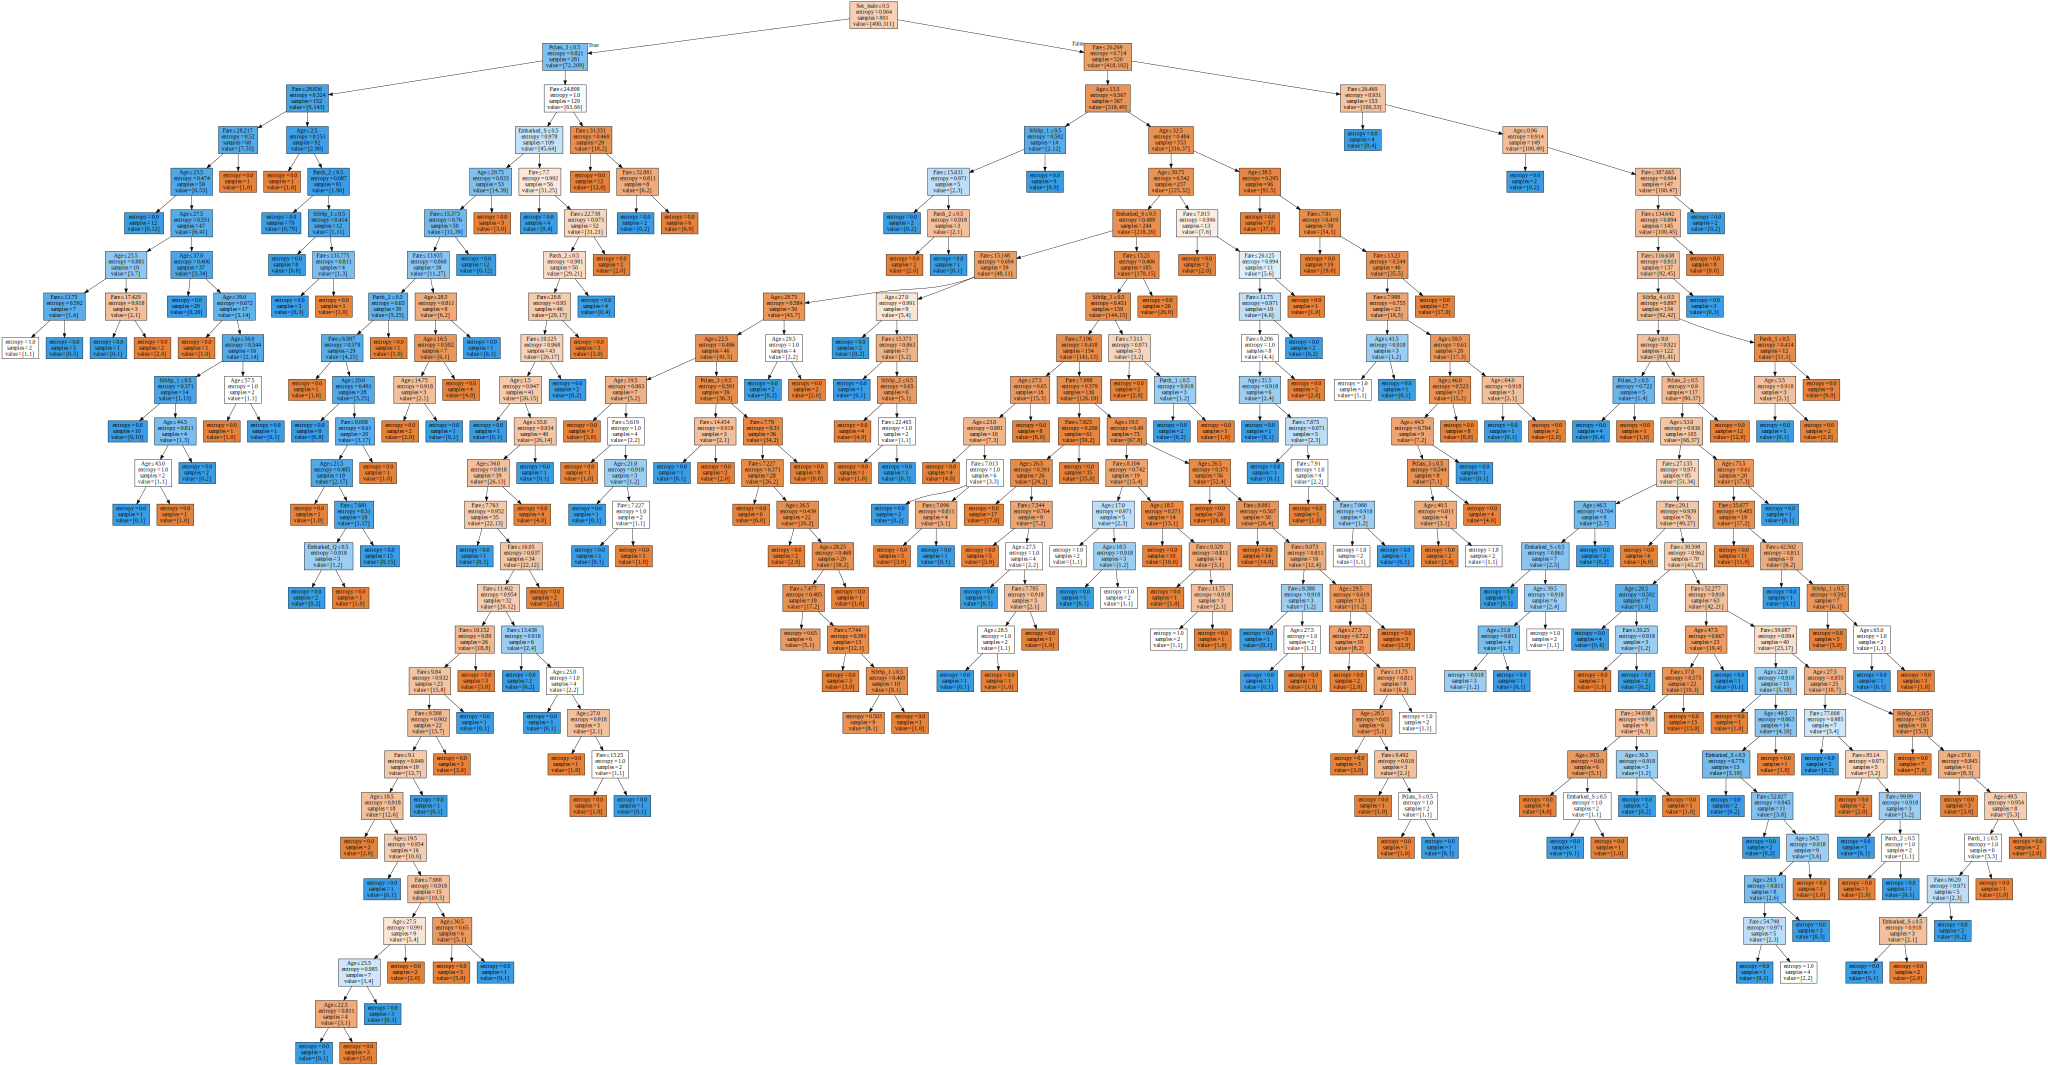

In [21]:
from sklearn.tree import export_graphviz
export_graphviz(clf_tree,out_file="clftree.dot", feature_names=X_train.columns,impurity=True,filled=True, special_characters=True)
###visualize the .dot file. Need to install graphviz seperately at first 
import graphviz
with open("clftree.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

In [39]:
#Отрисовать дерево можно вот так:   
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (150,150), dpi=100)
tree.plot_tree(clf_tree, feature_names = X_train.columns, max_depth = 4);

## Сравнение метрик

In [26]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [27]:
assert abs(my_roc_test - 0.6) >= 0.2